# Forecasting with ARMA Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/05-ARMA-Fitting-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>


In [3]:
# A purely random process with a standard deviation of 1

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# AR(1) parameters
phi_1 = 0.8  # AR coefficient
phi_2 = -0.6
theta_1 = 0.6  # MA coefficient
theta_2 = -0.4
sigma = 1  # standard deviation of noise
n = 100

noise = arma_generate_sample(ar=[1], ma=[1], nsample=n, scale=sigma)
ar1 = arma_generate_sample(ar=[1, -phi_1], ma=[1], nsample=n, scale=sigma)
ar2 = arma_generate_sample(ar=[1, -phi_1, -phi_2], ma=[1], nsample=n, scale=sigma)
ma1 = arma_generate_sample(ar=[1], ma=[1, theta_1], nsample=n, scale=sigma)
ma2 = arma_generate_sample(ar=[1], ma=[1, theta_1, theta_2], nsample=n, scale=sigma)

## Fitting AR(p) Models

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where $e_t \sim N(0, \sigma_e^2), E(e_t e_{t-k}) = 0 \text{ for } k \neq 0$.

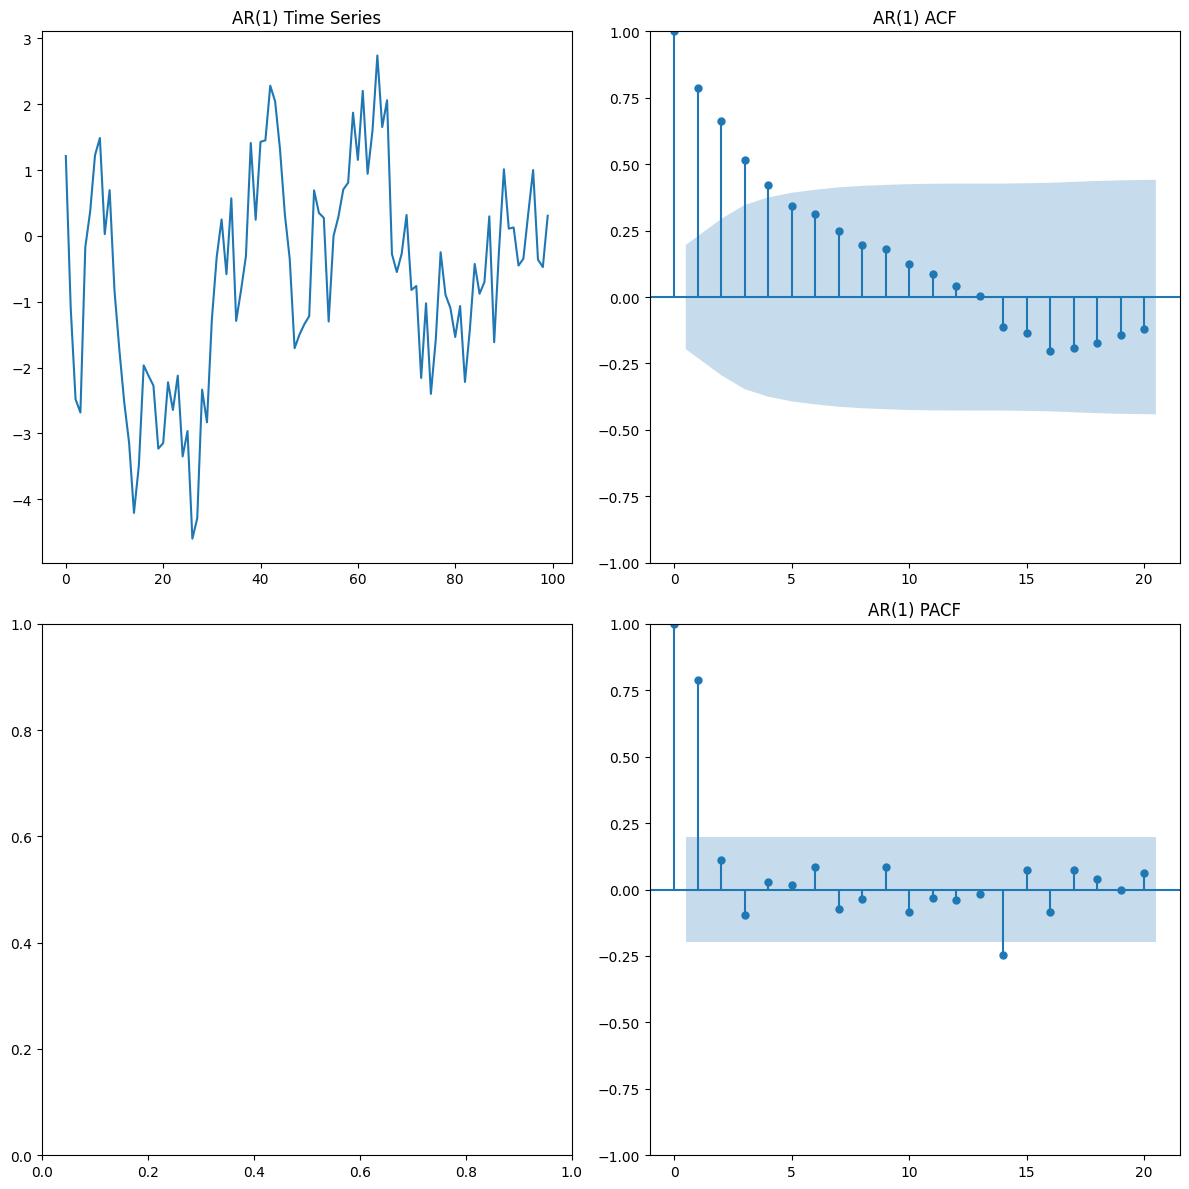

In [4]:
# Plot the ar1 series and its ACF and PACF

fix, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(ar1)
ax[0, 0].set_title('AR(1) Time Series')
plot_acf(ar1, ax=ax[0, 1], lags=20)
ax[0, 1].set_title('AR(1) ACF')
plot_pacf(ar1, ax=ax[1, 1], lags=20)
ax[1, 1].set_title('AR(1) PACF')
plt.tight_layout()
plt.show()

In [21]:
# Use statsmodels to fit an AR(1) model and print the summary

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

model_ar1 = ARIMA(ar1, order=(1, 0, 0))
model_ar1_fit = model_ar1.fit()

print(model_ar1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -139.007
Date:                Mon, 10 Nov 2025   AIC                            284.014
Time:                        12:55:49   BIC                            291.829
Sample:                             0   HQIC                           287.177
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5121      0.455     -1.126      0.260      -1.403       0.379
ar.L1          0.7936      0.060     13.123      0.000       0.675       0.912
sigma2         0.9346      0.173      5.407      0.0

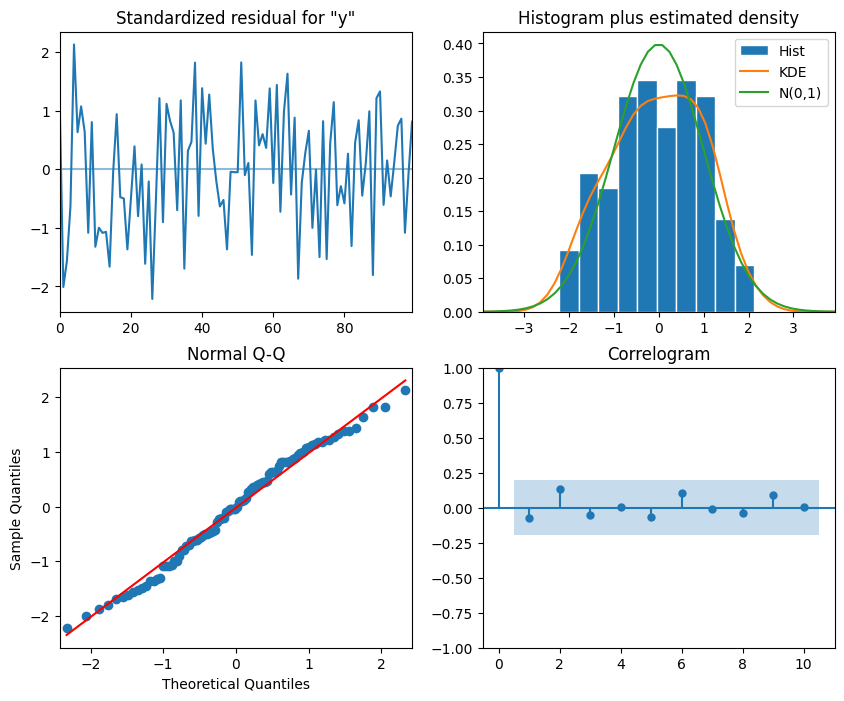

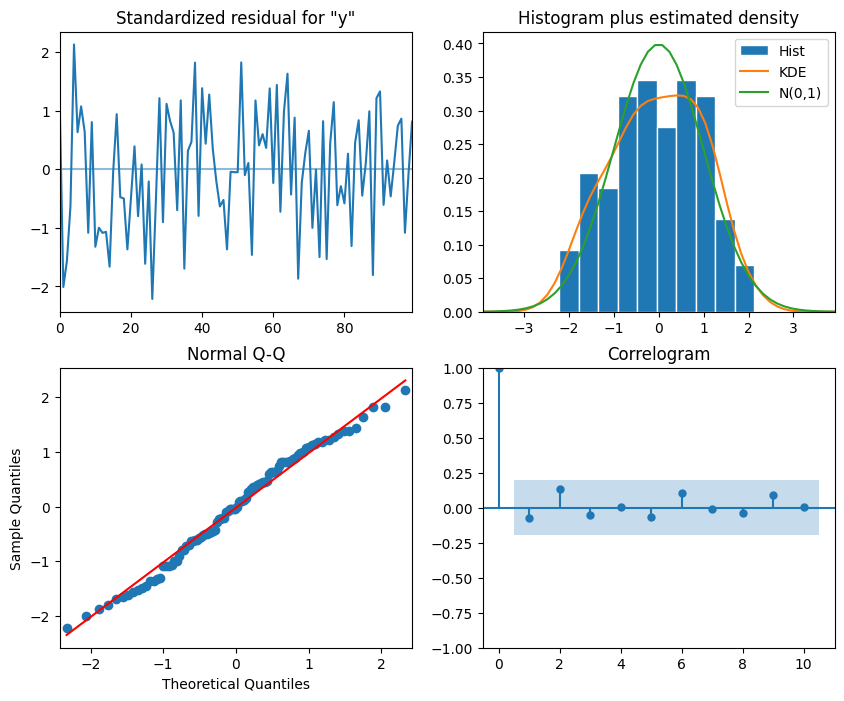

In [6]:
model_ar1_fit.plot_diagnostics(figsize=(10, 8))

## The Jung-Box Test

$$
Q=T(T+2)\sum _{k=1}^{h}{\frac {{\hat {\rho }}_{k}^{2}}{T-k}} \underset{H_0}{\sim} \chi(h)
$$

$$
\begin{align*}
H_0: & \rho_1 = \rho_2 = \ldots = \rho_{h} \\
H_1: & \text{ at least one of } \rho_k \neq 0, \quad k = 1,\ldots, h
\end{align*}
$$

In [53]:
lb_serial_corr = model_ar1_fit.test_serial_correlation("ljungbox")

for i, (stat, p) in enumerate(zip(lb_serial_corr[0][0], lb_serial_corr[0][1])):
    print(f"Lag {i}, test statistic = {stat:.3f} with p-value {p:.3f}")

Lag 0, test statistic = 0.572 with p-value 0.449
Lag 1, test statistic = 2.500 with p-value 0.286
Lag 2, test statistic = 2.787 with p-value 0.426
Lag 3, test statistic = 2.787 with p-value 0.594
Lag 4, test statistic = 3.274 with p-value 0.658
Lag 5, test statistic = 4.397 with p-value 0.623
Lag 6, test statistic = 4.402 with p-value 0.733
Lag 7, test statistic = 4.581 with p-value 0.801
Lag 8, test statistic = 5.442 with p-value 0.794
Lag 9, test statistic = 5.444 with p-value 0.860


In [20]:
from statsmodels import api as sm

# Ljung-Box test
lb = sm.stats.acorr_ljungbox(model_ar1_fit.resid, lags=[1], return_df=True, model_df=0)
print(lb)

    lb_stat  lb_pvalue
1  0.771558   0.379735
